In [25]:
import numpy as np 
np.random.seed(42)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import keras

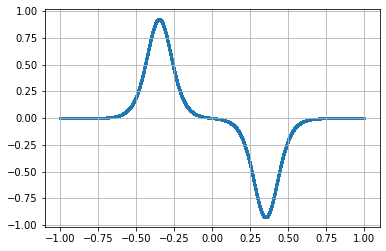

In [27]:
x_data = np.linspace(-1, 1, num=100000)
y_data = - np.tanh(10*x_data-3) - np.tanh(10*x_data+3)+ np.tanh(10*x_data-4) + np.tanh(10*x_data+4) + 0.0001*np.random.normal(size=100000)

plt.scatter(x_data[::1], y_data[::1], s=2)
plt.grid()
plt.show()

In [82]:
x_train1 = x_data[:len(x_data) - len(x_data)//10]
x_test = x_data[len(x_data) - len(x_data)//10:]
print(len(x_train),len(x_test))

y_train1 = y_data[:len(y_data) - len(y_data)//10]
y_test = y_data[len(y_data) - len(y_data)//10:]
print(len(y_train),len(y_test))

x_train = x_train1[:len(x_train1) - len(x_train1)//10]
x_val = x_train1[:len(x_train1) - len(x_train1)//10]
print(len(x_train),len(x_test))

y_train = y_train1[:len(y_train1) - len(y_train1)//10]
y_val = y_train1[:len(y_train1) - len(y_train1)//10]
print(len(y_train),len(y_test))

train_data = []
for i in range(0,len(x_train)):
  train_data.append([x_train[i], y_train[i]])

test_data = []
for i in range(0,len(x_test)):
  test_data.append([x_test[i],y_test[i]])
len(train_data)

x_train = np.transpose(x_train)
y_train = np.transpose(y_train)
x_test = np.transpose(x_test)
y_test = np.transpose(y_test)


90000 10000
90000 10000
81000 10000
81000 10000


In [29]:
class Layer:
    
    def __init__(self):
        pass
    
    def forward(self, input):
        return input    
    
    def backward(self, input, grad_output):
        num_units = input.shape[1]   
        d_layer_d_input = np.eye(num_units)
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [30]:
class relu(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad

In [31]:
def sigmoid(x):
    s=1/(1+np.exp(-x))
    ds=s*(1-s)  
    return s,ds

class sigmoid(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return sigmoid(input)[0]
    
    def backward(self, input, grad_output):
        return sigmoid(input)[1]*grad_output


In [32]:

def tanh1(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    dt=1-t**2
    return t,dt

class tanh(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return tanh1(input)[0]
    
    def backward(self, input, grad_output):
        return tanh1(input)[1]*grad_output

In [48]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(1/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [109]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    logits_for_answers = logits - reference_answers
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):

    ones_for_answers = np.zeros_like(logits)
    ones_for_answers = reference_answers
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [110]:
network = []
network.append(Dense(1,64))
network.append(relu())
network.append(Dense(64,64))
network.append(relu())
network.append(Dense(64,1))

def forward(network, X):
    activations = []
    input = X    
    for l in network:
        activations.append(l.forward(input))
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):  
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
    
def train(network,X,y):
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  
    logits = layer_activations[-1]
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) 
    return np.mean(loss)

In [113]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

from IPython.display import clear_output
train_log = []
val_log = []
X_train, y_train, X_val, y_val, X_test, y_test = x_train, y_train, x_val, y_val, x_test, y_test
for epoch in range(25):    

  for x_batch,y_batch in iterate_minibatches(x_train,y_train,batchsize=64,shuffle=True):
        train(network,x_batch.reshape(64,1),y_batch.reshape(64,1))
        


print("Training Done")

  0%|          | 0/1265 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 1265/1265 [00:00<00:00, 2553.17it/s]

Training Done


In [114]:
from sklearn.metrics import mean_squared_error 

mean_squared_error(predict(network,X_test[:64].reshape(64,1)),y_test[:64]) 

3.2029226719186666e-07